## Quantum Fourier Transform
#### In this tutorial, we will demonstrate the capabilities of qBraid Algorithms QFT and Inverse QFT (IQFT) Modules
Begin by importing the modules from qBraid Algorithms library

In [2]:
import pyqasm
from qbraid_algorithms import qft
from qbraid_algorithms import iqft

We can load both QFT and IQFT as PyQASM modules by calling the `load_program` method, passing the number of qubits to apply the operations to.

In [3]:
num_qubits = 3
qft_module = qft.load_program(num_qubits)
iqft_module = iqft.load_program(num_qubits)

We can perform all standard [PyQASM](https://docs.qbraid.com/pyqasm/user-guide/overview) operations on the module, such as unrolling.

In [4]:
qft_module.unroll()
iqft_module.unroll()

In [5]:
qft_str = pyqasm.dumps(qft_module)
iqft_str = pyqasm.dumps(iqft_module)

Below, we display a preview of the the unrolled QFT circuit, followed by the IQFT circuit.

In [6]:
print("\n".join(qft_str.split("\n")[:10]) + "\n...\n" + "\n".join(qft_str.split("\n")[-10:]))

OPENQASM 3.0;
include "stdgates.inc";
qubit[3] q;
bit[3] b;
h q[0];
rz(0.7853981633974483) q[1];
rx(1.5707963267948966) q[1];
rz(3.141592653589793) q[1];
rx(1.5707963267948966) q[1];
rz(3.141592653589793) q[1];
...
rx(1.5707963267948966) q[1];
rz(3.141592653589793) q[1];
rx(1.5707963267948966) q[1];
rz(3.141592653589793) q[1];
h q[2];
swap q[0], q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];



In [7]:
print("\n".join(iqft_str.split("\n")[:10]) + "\n...\n" + "\n".join(iqft_str.split("\n")[-10:]))

OPENQASM 3.0;
include "stdgates.inc";
qubit[3] q;
bit[3] b;
h q[2];
rz(-0.7853981633974483) q[2];
rx(1.5707963267948966) q[2];
rz(3.141592653589793) q[2];
rx(1.5707963267948966) q[2];
rz(3.141592653589793) q[2];
...
rx(1.5707963267948966) q[0];
rz(3.141592653589793) q[0];
rx(1.5707963267948966) q[0];
rz(3.141592653589793) q[0];
h q[0];
swap q[0], q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];



## Using Quantum Fourier Transform in your own OpenQASM3 program
#### qBraid algorithms makes it easy to incorporate QFT and IQFT into your own OpenQASM3 circuit.
To use a QFT/IQFT in your circuit, first generate the subroutine using the `generate_subroutine` method, which takes the number of qubits to use. The method will create a QASM3 file containing the algorithm as a subroutine within your current working directory.

In [8]:
qft.generate_subroutine(3)
iqft.generate_subroutine(3)

Subroutine 'qft' has been added to /Users/lukeandreesen/qbraid_algos/examples/qft.qasm
Subroutine 'iqft' has been added to /Users/lukeandreesen/qbraid_algos/examples/iqft.qasm


To use the QFT subroutine in your own circuit, add `include "qft.qasm";` to your OpenQASM file, and call the `qft` method by passing an appropriately sized register of qubits.

In [9]:
%cat qft.qasm

OPENQASM 3.0;
include "stdgates.inc";


def qft(qubit[3] q) {
  int n = 3;
  for int[16] i in [0:n - 1] {
    h q[i];
    for int[16] j in [i + 1:n - 1] {
      int[16] k = j - i;
      cp(2 * pi / (1 << (k + 1))) q[j], q[i];
    }
  }

  for int[16] i in [0:(n >> 1) - 1] {
    swap q[i], q[n - i - 1];
  }
}

To use the IQFT subroutine in your own circuit, add `include "qft.qasm";` to your OpenQASM file, and call the `qft` method by passing an appropriately sized register of qubits.

In [10]:
%cat iqft.qasm

OPENQASM 3.0;
include "stdgates.inc";

def iqft(qubit[3] q) {
    int n = 3;
  
    for int[16] i in [0:n-1] {
        int[16] target = n - i - 1;
        for int[16] j in [0:(n - target - 2)] {
            int[16] control = n - j - 1;
            int[16] k = control - target;
            cp(-2 * pi / (1 << (k + 1))) q[control], q[target];
        }
        h q[target];
    }

    for int[16] i in [0:(n >> 1) - 1] {
        swap q[i], q[n - i - 1];
    }
}

## Running Algorithms on qBraid
Running algorithms on qBraid is simple. First, import QbraidProvider from qBraid Runtime. Visit [here](https://docs.qbraid.com/sdk/user-guide/providers/native#qbraidprovider) for more information.

In [11]:
from qbraid.runtime import QbraidProvider

/opt/homebrew/lib/python3.11/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.30 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


If you have not yet configured QbraidProvider, provide your API key.

In [12]:
# provider = QbraidProvider(api_key='API_KEY')
provider = QbraidProvider()

We'll run our program on qBraid's QIR simulator.

In [13]:
device = provider.get_device("qbraid_qir_simulator")

To run the job, simply pass a QASM string to the device. If you have a PyQASM module, use `dumps` to generate a QASM string

In [14]:
module = qft.load_program(4)
qasm_str = pyqasm.dumps(module)

In [15]:
job = device.run(qasm_str, shots=500)

We can now get the counts from the job results.

In [17]:
results = job.result()
counts = results.data.get_counts()
print(counts)

{'0000': 21, '0001': 39, '0010': 27, '0011': 35, '0100': 4, '0101': 4, '0110': 34, '0111': 16, '1000': 25, '1001': 18, '1010': 14, '1011': 8, '1100': 54, '1101': 58, '1110': 69, '1111': 74}


Finally, we can plot the results using qBraid Visualization.

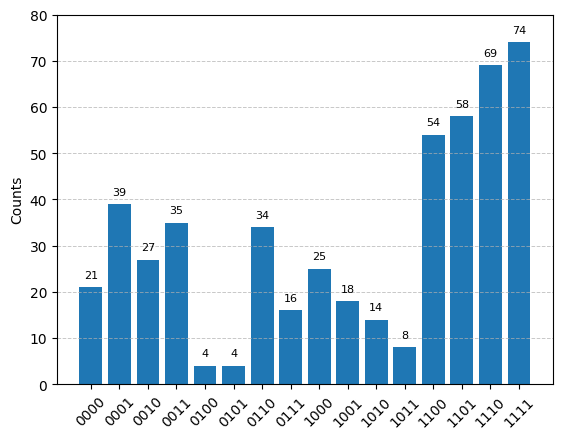

In [18]:
from qbraid.visualization import plot_histogram

plot_histogram(counts)